# The impact of rookie QBs on the win probability

As we are now in the second half of the 2020 NFL season, I thought it would be interesting to compare the production of the rookie quarterbacks, i.e. Joe Burrow for the Cincinnati Bengals, Tua Tagovailoa for the Miami Dolphins and Justin Herbert for the Los Angeles Chargers. What interested me specifically was the impact of their passing game on the win probability, and if it was possible to break it down for each type of pass (deep left, middle right, etc.) 

Before diving into the data, I have to thank [@mnpykings](https://twitter.com/mnpykings) for his incredible [tutorial on the nflfastR with Python](https://github.com/maxbolger/nflfastR-Python-Tutorial/blob/main/nflfastR_python_tutorial.ipynb) and [Hajime Alabanza](https://medium.com/@hajimealabanza?source=post_page-----fe9bb2f37116--------------------------------]) for his fascinating [article](https://medium.com/@hajimealabanza/did-the-new-orleans-saints-add-the-missing-piece-to-their-offense-fe9bb2f37116) on the Saints and his use of the WPA. As he wrote, WPA "is a metric that measures how much more likely a team is to win a game after a given play." In other words, each action impacts the probabilities to win the game, either positively or negatively. This impact is quantified and recorded as "WPA", "Win Probability Added".

## 1 : Import of the librairies and data

Let's begin by importing the different librairies needed:
- numpy and pandas for the cleaning and the handling of the data
- matplotlib and seaborn for the visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Now we download the most recent play-by-play results of the NFL into a dataframe simply called "data". By the time I wrote this article, one game was left to play for week 10 but it doesn't have an impact on this analysis.

In [2]:
# Single season
YEAR = 2020
data = pd.read_csv(
    'https://github.com/guga31bb/nflfastR-data/blob/master/data/play_by_play_' \
    + str(YEAR) + '.csv.gz?raw=True',compression='gzip', low_memory=False
   )

## 2. Cleaning and modification of the data

The table contains 2 columns defining the type of the pass:
- pass_length : short or deep
- pass_location : left, middle, or right

We'll create a new column called "pass_type" by concatenating these two.

Next, we'll calculate a new column called "wpa_pct" by multiplying the current wpa by 100.

In [3]:
data['pass_type'] = data['pass_length'] + ' - ' + data['pass_location']
data['wpa_pct'] = (100*data['wpa'])

Let's remove the data we do not want for our analysis, like kneel downs, field goals, penalties, etc, and assign this new dataframe to "df".

In [4]:
df = data[
    (data.play_type.isin(['no_play','pass','run'])) &
    (data.sack==0) &      
    (data.two_point_attempt==0) &
    (data['epa'].isna()==False)
    ]

Let's take a moment to state the obvious: it is correct that the results we'll get are biased. Indeed, Burrow and Herbert have both played the entirety of the season (or 8 out of 9 games for Herbert) while Tua has officially played only 4 matches, and for his first match, he only threw 2 passes as he entered late in the game and only played 5 snaps. We accept this bias as our objective is to get a snap shot of their season so far.

In order to do this, we'll take their data into a new dataframe called "rookies_df" and calculate their basic stats:

In [5]:
rookies_df = df[df.passer_player_name.isin(['T.Tagovailoa','J.Burrow','J.Herbert'])]

rookies_df.groupby('passer_player_name').agg(
    games_played=('game_id', 'nunique'),
    pass_attempts=('pass_attempt', 'sum'),
    complete_passes=('complete_pass', 'sum'),
    total_yards_gained=('yards_gained','sum'),
    TD=('pass_touchdown','sum'),
    interceptions=('interception','sum')
)

,games_played,pass_attempts,complete_passes,total_yards_gained,TD,interceptions
passer_player_name,,,,,,
J.Burrow,9,367.0,242.0,2485.0,12.0,5.0
J.Herbert,8,297.0,200.0,2328.0,19.0,6.0
T.Tagovailoa,4,76.0,49.0,519.0,5.0,0.0


## 3: Focus on the wpa

Now we can focus on the wpa stat. One way to analyze them is to group them in a single table:

In [6]:
table = pd.pivot_table(rookies_df, values='wpa_pct', index=['passer_player_name'],columns=['pass_type'], aggfunc=np.mean)
rookies_grouped = table.transpose()
rookies_grouped

passer_player_name,J.Burrow,J.Herbert,T.Tagovailoa
pass_type,,,
deep - left,-0.202351,2.027038,0.608190
deep - middle,-1.698436,0.644841,3.416979
deep - right,0.378192,4.134274,0.970340
short - left,0.456855,0.556691,0.551655
short - middle,0.879427,0.568895,1.195688
short - right,1.448731,0.128161,0.481609


We have the results, but it's clearly not the best way to compare them. What we are going to do is use an heatmap to represent the field and put the data in a way that is more interesting to the eye.

In order to achieve this, we'll follow several steps:

- Isolate the stats of a QB
- Transform the dataframe in order to have data presented in the same order as in the visualization we want to get
- Rename the index and columns for more convenience
- Repeat the exact same steps for the other QBs

In [7]:
Burrow_WPA = rookies_grouped['J.Burrow'].reset_index()
Burrow_plot_data = (Burrow_WPA.join(Burrow_WPA['pass_type'].str.split(' - ', expand=True))
               .pivot(index=0, columns=1, values='J.Burrow')
            )

Burrow_plot_data.index.name = "Pass length"
Burrow_plot_data.columns.name = "Pass location"

In [8]:
Tagovailoa_WPA = rookies_grouped['T.Tagovailoa'].reset_index()
Tagovailoa_plot_data = (Tagovailoa_WPA.join(Tagovailoa_WPA['pass_type'].str.split(' - ', expand=True))
               .pivot(index=0, columns=1, values='T.Tagovailoa')
            )

Tagovailoa_plot_data.index.name = "Pass length"
Tagovailoa_plot_data.columns.name = "Pass location"

In [9]:
Herbert_WPA = rookies_grouped['J.Herbert'].reset_index()
Herbert_plot_data = (Herbert_WPA.join(Herbert_WPA['pass_type'].str.split(' - ', expand=True))
               .pivot(index=0, columns=1, values='J.Herbert')
            )

Herbert_plot_data.index.name = "Pass length"
Herbert_plot_data.columns.name = "Pass location"

Now that we have the data for each QB, we can pass them into a seaborn heatmap, adjust the parameters to make it more interesting (color bar going from red to green, use the same scale for every graph, etc.) and call them.

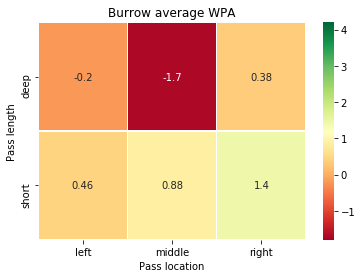

In [10]:
ax = sns.heatmap(Burrow_plot_data, annot=True, linewidths=.4,cmap="RdYlGn",vmin=-1.8,vmax=4.2)
plt.title('Burrow average WPA')
plt.show()

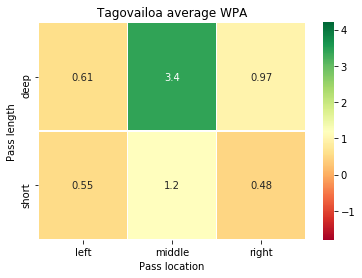

In [11]:
T_ax = sns.heatmap(Tagovailoa_plot_data, annot=True, linewidths=.4,cmap="RdYlGn",vmin=-1.8,vmax=4.2)
plt.title('Tagovailoa average WPA')
plt.show()

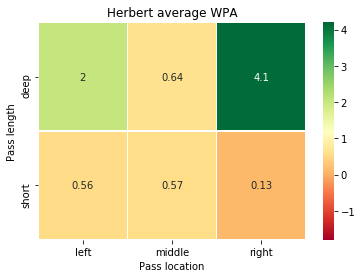

In [12]:
H_ax = sns.heatmap(Herbert_plot_data, annot=True, linewidths=.4,cmap="RdYlGn",vmin=-1.8,vmax=4.2)
plt.title('Herbert average WPA')
plt.show()

As we can seeon the charts, Joe Burrows is quite at ease with the short right passes, as they add in average 1.4 points of win probability, but he seems to struggle a lot with the middle deep pass, as they have an average wpa of -1.7.

On the other hand, this is precisely where Tagovailoa is the most impactful : his deep middle passes add on average 3.4 point of win probability!

Herbert, for his part, excels with the deep right pass: it is even the most impactful pass of the 3 QBs, as it reaches an average of 4.1 points of WPA. 

Sure, as I said earlier, this is a biaised comparison as Burrow and Herbert have played more than twice the number of games of Tua, and the sample size is realtively small, but this provides some interesting data for the end of this season!